# Training Baseline

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tempfile
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
import torch.quantization as tq
from torchvision import datasets, transforms
from tqdm import tqdm
import os

In [2]:
# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


## Loading Dataset
- MNIST
- train, validation and test-datasets

train size: 50000
val size: 10000
test size: 10000

batch size: 64

random sample sample:


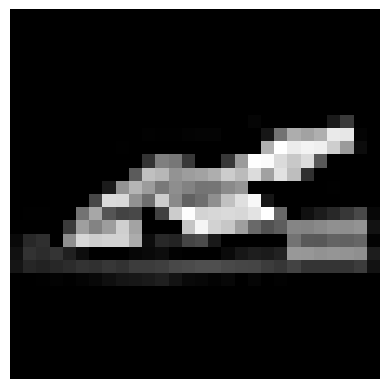

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])


class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# class_names = ["o", "ki", "su", "tsu", "na", "ha", "ma", "ya", "re", "wo"]

# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1), # Make it Black & White
#     transforms.Resize((28, 28)),                 # Shrink to MNIST size
#     transforms.ToTensor()
# ])

# class_names = [
#     "airplane", "automobile", "bird", "cat", "deer", 
#     "dog", "frog", "horse", "ship", "truck"
# ]

# Download MNIST
full_train = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# Split: 50k train / 10k validation
train_size = 50_000
val_size = 10_000
unused_size = len(full_train) - train_size - val_size

train_dataset, val_dataset, _ = random_split(
    full_train, [train_size, val_size, unused_size]
)

# Dataloaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def get_calib_loader(num_samples=1000, batch_size=batch_size):
    indices = torch.randperm(len(train_dataset))[:num_samples]
    calib_dataset = Subset(train_dataset, indices)
    calib_loader = DataLoader(calib_dataset, batch_size=batch_size, shuffle=False)
    return calib_loader

calib_loader = get_calib_loader(100)
    

print("train size:", len(train_dataset))
print("val size:", len(val_dataset))
if unused_size > 0:
    print("unused_size:", unused_size)
print("test size:", len(test_dataset))
print("\nbatch size:", batch_size)

print("\nrandom sample sample:")
idx = random.randint(0, len(test_dataset) - 1)
img_tensor, label = test_dataset[idx]
plt.imshow(img_tensor.squeeze(), cmap="gray")  # squeeze turns (1, 28, 28) to (28, 28) i think
plt.axis("off")
plt.show()

## Model Definition
- The NN-Architecture does not change

In [4]:
class FP32(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1, bias=False)  # bias=False because bn1 has its own bias
        self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        
        self.pool1  = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1, bias=False)  # bias=False because bn1 has its own bias
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        
        self.pool2  = nn.MaxPool2d(2)

        # 16 channels and 28 / 2 / 2 = 7 (two pools)
        self.fc1 = nn.Linear(16 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

## Generic Training and Evaluation Methods

In [5]:
def train_one_epoch(model, loader, optimizer, criterion, epoch_num=1):
    model.train()  # just sets the mode :)
    total_loss = 0.0

    loader_with_tqdm = tqdm(loader, desc=f"Training Epoch {epoch_num}")
    loader_with_tqdm.total = len(loader)

    for x, y in loader_with_tqdm:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [6]:
@torch.no_grad()
def evaluate(net, loader):
    net.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    total_time = 0
    avg_time = 0

    # loader_with_tqdm = tqdm(enumerate(loader), desc=f"Evaluating Model")
    # loader_with_tqdm.total = len(loader)

    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        start = time.perf_counter()
        out = net(x)
        end = time.perf_counter()

        total_time += end - start
        avg_time += (end - start - avg_time) / (i + 1)
        
        loss = criterion(out, y)

        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    avg_time /= batch_size

    avg_latency_ms = avg_time * 1000
    throughput = 1 / avg_time
    acc = correct / total
    
    return total_loss / len(loader), acc, total_time, avg_latency_ms, throughput

In [7]:
def model_size_mb(model) -> float:
    with tempfile.NamedTemporaryFile(delete=False) as tmp:
        torch.save(model.state_dict(), tmp.name)
        size_mb = os.path.getsize(tmp.name) / (1024 ** 2)
    os.remove(tmp.name)
    return size_mb

In [8]:
def test(net, model_name="CNN"):
    test_loss, test_acc, total_time, latency, throughput = evaluate(net, test_loader)
    test_size = model_size_mb(net)

    print(f"-- Evaluating {model_name} --")
    print(f"{model_name} evaluation finished in {total_time:.4f}s")
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} Model Size: {test_size:.4f}MB")
    print(f"{model_name} Inference Latency: {latency:.4f}ms")
    print(f"{model_name} Inference Throughput per second: {throughput:.0f}")
    print()

In [9]:
def calculating_avg_latency(net, iterations=10):
    total_avg_lat = 0
    for _ in range(iterations):
        _, _, _, avg, _ = evaluate(net, test_loader)
        total_avg_lat += avg
    avg_latency_ms = total_avg_lat / iterations
    return avg_latency_ms

## Training
- Train once or load if exists (if already trained)

In [10]:
model_path = "./models/fp32.pth"

model = FP32().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

val_accuracies = []
epoch_train_times = []

if os.path.exists(model_path):
    print("Loading trained FP32 model from disk...")
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))

else:
    print("Training FP32 model...")

    for epoch in range(num_epochs):
        
        start = time.time()
        _ = train_one_epoch(
            model, train_loader, optimizer, criterion, epoch_num=epoch+1
        )
        epoch_time = time.time() - start
        
        _, val_acc, _, _, _ = evaluate(
            model, val_loader
        )

        epoch_train_times.append(epoch_time)
        val_accuracies.append(val_acc)

        print(f"Trained Epoch {epoch+1} in {epoch_time} seconds with val_accuracy: {val_acc:.4f}")

    print("Training finished")

    total_training_time = sum(epoch_train_times)
    print(f"Total Time trained: {total_training_time}")
    print(f"Avg. Time per Epoch: {total_training_time / num_epochs}")
    
    torch.save(model.state_dict(), model_path)
    print("Model saved to:", model_path)

Loading trained FP32 model from disk...


## Evaluation
- generic method

In [11]:
test(model, model_name="PTQ Naive")

-- Evaluating PTQ Naive --
PTQ Naive evaluation finished in 0.2282s
PTQ Naive Test Accuracy: 0.9063
PTQ Naive Model Size: 0.3982MB
PTQ Naive Inference Latency: 0.0227ms
PTQ Naive Inference Throughput per second: 44023



## Experiments

In [12]:
print(len(train_loader))
print(len(test_loader) * batch_size)

782
10048


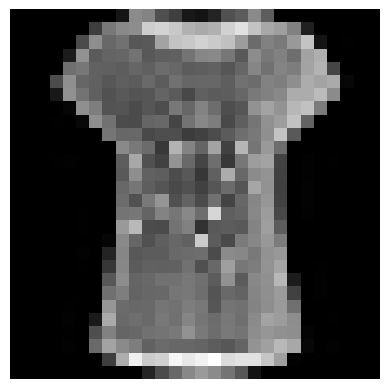

Actual Label: T-shirt/top
Prediction:   T-shirt/top
Result:       ✅ Correct


In [13]:
def visualize_prediction(model, dataset):
    idx = random.randint(0, len(dataset) - 1)
    img_tensor, label = dataset[idx]
    plt.imshow(img_tensor.squeeze(), cmap="gray")  # squeeze turns (1, 28, 28) to (28, 28) i think
    plt.axis("off")
    plt.show()
    
    # Inference
    model.eval()
    input_batch = img_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_batch)
        prediction = output.argmax(dim=1).item()
    
    pred_name = class_names[prediction]
    gt_name   = class_names[label]

    print(f"Actual Label: {gt_name}")
    print(f"Prediction:   {pred_name}")
    
    if prediction == label:
        print("Result:       ✅ Correct")
    else:
        print("Result:       ❌ Incorrect")

visualize_prediction(model, test_dataset)

# PTQ (Naive)

In [14]:
class NaivePTQ(FP32):
    def __init__(self):
        super().__init__()
        self.quant = torch.quantization.QuantStub()  # introduces observers
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = super().forward(x)
        x = self.dequant(x)
        return x

In [15]:
net_ptq_naive = NaivePTQ().to(device)
net_ptq_naive.load_state_dict(model.state_dict())
net_ptq_naive.eval()

net_ptq_naive.qconfig = torch.ao.quantization.default_qconfig
net_ptq_naive = torch.ao.quantization.prepare(net_ptq_naive)  # insert observers for callibration / MinMaxObservers
net_ptq_naive

NaivePTQ(
  (conv1): Conv2d(
    1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn1): BatchNorm2d(
    8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(
    8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn2): BatchNorm2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(
    in_features=784, out_features=128, bias=True
    (activation_post_process): MinMaxObs

### Callibrate with evaluation

In [16]:
# calibration
evaluate(net_ptq_naive, calib_loader)

(0.18730862066149712,
 0.95,
 0.005401400034315884,
 0.042198437768092845,
 23697.559741325822)

In [17]:
# printing all observed min and max values
net_ptq_naive

NaivePTQ(
  (conv1): Conv2d(
    1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=-1.4034017324447632, max_val=0.9072180390357971)
  )
  (bn1): BatchNorm2d(
    8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=-6.621782302856445, max_val=7.239716053009033)
  )
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(
    8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=-4.817370414733887, max_val=4.71750545501709)
  )
  (bn2): BatchNorm2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=-8.152894973754883, max_val=9.738616943359375)
  )
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [18]:
# actual quantization:
net_ptq_naive = torch.ao.quantization.convert(net_ptq_naive)
net_ptq_naive

NaivePTQ(
  (conv1): QuantizedConv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), scale=0.018193857744336128, zero_point=77, padding=(1, 1), bias=False)
  (bn1): QuantizedBatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): QuantizedConv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.07507776468992233, zero_point=64, padding=(1, 1), bias=False)
  (bn2): QuantizedBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): QuantizedLinear(in_features=784, out_features=128, scale=0.3634507358074188, zero_point=78, qscheme=torch.per_tensor_affine)
  (relu3): ReLU()
  (fc2): QuantizedLinear(in_features=128, out_features=10, scale=0.4523157477378845, zero_point=73, qscheme=torch.per_tensor_affine)
  (quant): Quantize(scal

this results in assymatric quantization: Each layer has a scale and a zero_point to quantized the values

### Compare weights with baseline

In [19]:
print(f"Weights of FT32 baseline:")
print(model.conv1.weight[0])
print("\n")
print(f"Quantized Weights of naive_ptq:")
print(torch.int_repr(net_ptq_naive.conv1.weight()[0]))
print("\n")
print(f"Dequantized Weights of naive_ptq:")
print(torch.dequantize(net_ptq_naive.conv1.weight()[0]))

Weights of FT32 baseline:
tensor([[[-0.0369, -0.2181,  0.1400],
         [-0.1315, -0.0623,  0.3308],
         [-0.3941,  0.0820,  0.3094]]], grad_fn=<SelectBackward0>)


Quantized Weights of naive_ptq:
tensor([[[ -9, -54,  35],
         [-33, -15,  82],
         [-98,  20,  77]]], dtype=torch.int8)


Dequantized Weights of naive_ptq:
tensor([[[-0.0363, -0.2181,  0.1413],
         [-0.1333, -0.0606,  0.3311],
         [-0.3957,  0.0808,  0.3109]]])


### Evaluate PTQNaive

In [20]:
test(net_ptq_naive, model_name="PTQ Naive")

-- Evaluating PTQ Naive --
PTQ Naive evaluation finished in 0.3489s
PTQ Naive Test Accuracy: 0.9054
PTQ Naive Model Size: 0.1080MB
PTQ Naive Inference Latency: 0.0347ms
PTQ Naive Inference Throughput per second: 28801



# PTQ + Bias Correction

- Bias Correction operates layer-wise
- After PTQ a layer computes:
$$
y_q=W_qx_q+b
$$
- The Idea for Bias Correction:
$$
\mathbb{E}[W_qx_q]\neq\mathbb{E}[Wx]
$$
- fix in bias $b$ of NN:
$$
b'=b+\mathbb{E}[Wx]-\mathbb{E}[W_qx_q]
$$
- new output:
$$
y_q=W_qx_q+b'
$$

In [21]:
def collect_layer_outputs(net, loader, layers):
    outputs = {name: [] for name in layers}

    hooks = []

    def make_hook(name):
        def hook(module, inp, out):
            outputs[name].append(out.detach().cpu())
        return hook

    for name, module in net.named_modules():
        if name in layers:
            hooks.append(module.register_forward_hook(make_hook(name)))

    model.eval()
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            net(x)

    for h in hooks:
        h.remove()

    return {k: torch.cat(v, dim=0) for k, v in outputs.items()}

In [22]:
def bias_correction_pre_convert(fp32_model, prepared_model, calib_loader):
    layers = [
        name for name, m in fp32_model.named_modules()
        if isinstance(m, (nn.Conv2d, nn.Linear)) and m.bias is not None
    ]

    fp32_outs = collect_layer_outputs(fp32_model, calib_loader, layers)
    prep_outs = collect_layer_outputs(prepared_model, calib_loader, layers)

    for name in layers:
        fp32 = fp32_outs[name]
        prep = prep_outs[name]

        if fp32.dim() == 4:   # Conv
            delta = (fp32 - prep).mean(dim=(0, 2, 3))
        else:                 # Linear
            delta = (fp32 - prep).mean(dim=0)

        module = dict(prepared_model.named_modules())[name]
        module.bias.data += delta.to(module.bias.device)

    return prepared_model

In [23]:
net_bias = NaivePTQ().to(device)
net_bias.load_state_dict(model.state_dict())
net_bias.eval()

net_bias.qconfig = torch.ao.quantization.default_qconfig
torch.ao.quantization.prepare(net_bias, inplace=True)

NaivePTQ(
  (conv1): Conv2d(
    1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn1): BatchNorm2d(
    8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(
    8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn2): BatchNorm2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(
    in_features=784, out_features=128, bias=True
    (activation_post_process): MinMaxObs

In [24]:
fp32_ref = FP32().to(device)
fp32_ref.load_state_dict(model.state_dict())
fp32_ref.eval()

FP32(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [25]:
net_bias = bias_correction_pre_convert(
    fp32_ref,
    net_bias,
    calib_loader
)

net_bias = torch.ao.quantization.convert(net_bias)

In [26]:
test(net_bias, model_name="PTQ with Bias Correction")

-- Evaluating PTQ with Bias Correction --
PTQ with Bias Correction evaluation finished in 0.3514s
PTQ with Bias Correction Test Accuracy: 0.9054
PTQ with Bias Correction Model Size: 0.1080MB
PTQ with Bias Correction Inference Latency: 0.0350ms
PTQ with Bias Correction Inference Throughput per second: 28593



# PTQ + BN Folding

In [27]:
class PTQ_BN_Folding(FP32):
    def __init__(self):
        super().__init__()
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = super().forward(x)  # (Fusion will replace conv1+bn1+relu1 with a single ConvReLU module / same with conv2+bn2+relu2)
        x = self.dequant(x)
        return x

In [28]:
# Load weights from the trained BN model
net_ptq_fold = PTQ_BN_Folding().to(device)
net_ptq_fold.load_state_dict(model.state_dict())
net_ptq_fold.eval()

PTQ_BN_Folding(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
)

In [29]:
# Fusing Conv2d + BatchNorm2d + ReLU
torch.ao.quantization.fuse_modules(
    net_ptq_fold, 
    [['conv1', 'bn1', 'relu1'], ['conv2', 'bn2', 'relu2']], 
    inplace=True
)

PTQ_BN_Folding(
  (conv1): ConvReLU2d(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (bn1): Identity()
  (relu1): Identity()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): ConvReLU2d(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (bn2): Identity()
  (relu2): Identity()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
)

In [30]:
# Prepare (Insert Observers)
net_ptq_fold.qconfig = torch.ao.quantization.default_qconfig
torch.ao.quantization.prepare(net_ptq_fold, inplace=True)

PTQ_BN_Folding(
  (conv1): ConvReLU2d(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn1): Identity()
  (relu1): Identity()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): ConvReLU2d(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn2): Identity()
  (relu2): Identity()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(
    in_features=784, out_features=128, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu3): ReLU()
  (fc2): Linear(
    in_features=128, out_features=10, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (quant): QuantStub(
    (activation_post_pro

In [31]:
# Calibrate
evaluate(net_ptq_fold, calib_loader)

(0.18730862438678741,
 0.95,
 0.00480940006673336,
 0.03757343802135438,
 26614.546143785483)

In [32]:
# actual quantization
torch.ao.quantization.convert(net_ptq_fold, inplace=True)

PTQ_BN_Folding(
  (conv1): QuantizedConvReLU2d(1, 8, kernel_size=(3, 3), stride=(1, 1), scale=0.0570056326687336, zero_point=0, padding=(1, 1))
  (bn1): Identity()
  (relu1): Identity()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): QuantizedConvReLU2d(8, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.07668203115463257, zero_point=0, padding=(1, 1))
  (bn2): Identity()
  (relu2): Identity()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): QuantizedLinear(in_features=784, out_features=128, scale=0.3634507358074188, zero_point=78, qscheme=torch.per_tensor_affine)
  (relu3): ReLU()
  (fc2): QuantizedLinear(in_features=128, out_features=10, scale=0.4523157477378845, zero_point=73, qscheme=torch.per_tensor_affine)
  (quant): Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

In [33]:
# Evaluate
test(net_ptq_fold, model_name="PTQ with BN Folding")

-- Evaluating PTQ with BN Folding --
PTQ with BN Folding evaluation finished in 0.2256s
PTQ with BN Folding Test Accuracy: 0.9061
PTQ with BN Folding Model Size: 0.1047MB
PTQ with BN Folding Inference Latency: 0.0225ms
PTQ with BN Folding Inference Throughput per second: 44541



# Mixed Precision PTQ 

## Calculate Layerwise Error / Sensitivity

In [34]:
def get_layer_sensitivity(fp32_model, quantized_model, loader, num_batches=None):
    fp32_model.eval()
    quantized_model.eval()
    
    total_squared_errors = {} 
    total_counts = {}
    
    # temp - cleaned after every batch
    batch_fp32_out = {}
    batch_quant_out = {}
    
    target_prefixes = ("conv", "fc")

    def make_hook(storage_dict, layer_name):
        def hook(module, inp, out):
            if hasattr(out, "is_quantized") and out.is_quantized:
                out = out.dequantize()
            storage_dict[layer_name] = out.detach().cpu()
        return hook

    handles = []
    
    for name, mod in fp32_model.named_modules():
        if name.startswith(target_prefixes):
            handles.append(mod.register_forward_hook(make_hook(batch_fp32_out, name)))
            
    for name, mod in quantized_model.named_modules():
        if name.startswith(target_prefixes):
            handles.append(mod.register_forward_hook(make_hook(batch_quant_out, name)))
    
    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if num_batches and i >= num_batches:
                break
                
            x = x.to(device)
            
            batch_fp32_out.clear()
            batch_quant_out.clear()
            
            fp32_model(x)
            quantized_model(x)
            
            for name in batch_fp32_out.keys():
                if name in batch_quant_out:
                    out_f = batch_fp32_out[name]  # tensor
                    out_q = batch_quant_out[name]
                    
                    batch_squared_error = (out_f - out_q).pow(2).sum().item()
                    batch_count = out_f.numel()
                    
                    total_squared_errors[name] = total_squared_errors.get(name, 0.0) + batch_squared_error
                    total_counts[name] = total_counts.get(name, 0) + batch_count

    for h in handles:
        h.remove()

    final_sensitivity = {}
    for name in total_squared_errors:
        final_sensitivity[name] = total_squared_errors[name] / total_counts[name]

    return final_sensitivity

Starting robust sensitivity analysis...

Layer-wise MSE Error (Averaged over batches):
conv2: 0.465260
conv1: 0.324553
fc2: 0.047701
fc1: 0.019444


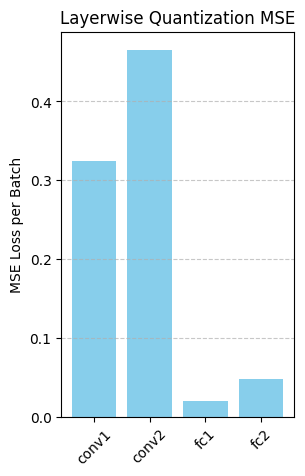

In [35]:
print("Starting robust sensitivity analysis...")
sensitivity = get_layer_sensitivity(
    model, 
    net_ptq_fold, 
    val_loader,
    num_batches=20
)

print("\nLayer-wise MSE Error (Averaged over batches):")
sorted_layers = sorted(sensitivity.items(), key=lambda item: item[1], reverse=True)
for name, score in sorted_layers:
    print(f"{name}: {score:.6f}")

# Plot
plt.figure(figsize=(3, 5))
plt.bar(sensitivity.keys(), sensitivity.values(), color='skyblue')
plt.title("Layerwise Quantization MSE")
plt.ylabel("MSE Loss per Batch")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# QAT

# Final Evaluation

In [36]:
test(model, model_name="FP32 Baseline")
test(net_ptq_naive, model_name="PTQ Naive")
test(net_bias, model_name="PTQ with Bias Correction")
test(net_ptq_fold, model_name="PTQ with BN Folding")

-- Evaluating FP32 Baseline --
FP32 Baseline evaluation finished in 0.2224s
FP32 Baseline Test Accuracy: 0.9063
FP32 Baseline Model Size: 0.3982MB
FP32 Baseline Inference Latency: 0.0221ms
FP32 Baseline Inference Throughput per second: 45175

-- Evaluating PTQ Naive --
PTQ Naive evaluation finished in 0.3549s
PTQ Naive Test Accuracy: 0.9054
PTQ Naive Model Size: 0.1080MB
PTQ Naive Inference Latency: 0.0353ms
PTQ Naive Inference Throughput per second: 28311

-- Evaluating PTQ with Bias Correction --
PTQ with Bias Correction evaluation finished in 0.3509s
PTQ with Bias Correction Test Accuracy: 0.9054
PTQ with Bias Correction Model Size: 0.1080MB
PTQ with Bias Correction Inference Latency: 0.0349ms
PTQ with Bias Correction Inference Throughput per second: 28631

-- Evaluating PTQ with BN Folding --
PTQ with BN Folding evaluation finished in 0.2223s
PTQ with BN Folding Test Accuracy: 0.9061
PTQ with BN Folding Model Size: 0.1047MB
PTQ with BN Folding Inference Latency: 0.0221ms
PTQ with B

In [37]:
print(f"FP32 latency: {calculating_avg_latency(model):.4f}ms")
print(f"PTQ Naive latency: {calculating_avg_latency(net_ptq_naive):.4f}ms")
print(f"PTQ Bias Correction latency: {calculating_avg_latency(net_bias):.4f}ms")
print(f"PTQ BN Folding latency: {calculating_avg_latency(net_ptq_fold):.4f}ms")

FP32 latency: 0.0224ms
PTQ Naive latency: 0.0352ms
PTQ Bias Correction latency: 0.0391ms
PTQ BN Folding latency: 0.0244ms
